# <h1><center> Customer Churn Prediction:  </center></h1>
# <h2><center> Leveraging Random Forest and SMOTE to Inform Data-driven Customer Retention Programs </center></h2>


# 1.0) Introduction:


## 1.1) Importance:

It is often recognized in business that acquiring new customers is significantly more expensive than retaining existing ones. 
In this project, we propose an **Random Forest model** to classify whether a customer will churn or not churn.  By identifying those customers likely to leave, the company would be well-placed to offer individuals incentives to stay, leading to improved retention and higher returns for every dollar spent on customer acquisition.


## 1.2) Methods:

To accomplish this goal, we will:
1. Perform **exploratory data analysis** (**EDA**) to derive insights regarding our data's features.
2. Perform **data cleaning**
3. Perform **feature engineering**
4. Train **Logistic Regression** and **Random Forest** models to predict customer churn


# 2.0)  Exploratory Data Analysis

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Install libraries
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from joblib import dump, load

# Load the data
X_full = pd.read_csv('C:/Users/Priya/Documents/Self Study/Customer churn/WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col='customerID')

print('The table has ', X_full.shape[0], ' unique customers')
print('The table has ', X_full.shape[1], ' features')

# Allow us to see all columns of our dataframe
pd.set_option('max_columns', None)

The table has  7043  unique customers
The table has  20  features


In [2]:
# Get a sense of our data
X_full.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2.1) Summarize our data

In [3]:
# Summarize our data
X_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

### <h3><center> Observations: </center></h3>
1. Most of our data is categorical
2. Our data contains no null values
3. Our numeric data is stored as either int64 or float64

`TotalCharges` seems to be an "object" datatype even though `MonthlyCharges` is represented as a "float"
This likely means that although values in this column seem to be integers, they are actually represented as strings (or a mixture of different datatypes).  We should investigate this before visualizing our numeric data.  But more on that later.


For now, let's take a look at the distribution of our target variable:  `Churn`

Customers who stayed:   5174
Customers who churned:   1869


Text(0, 0.5, 'Count')

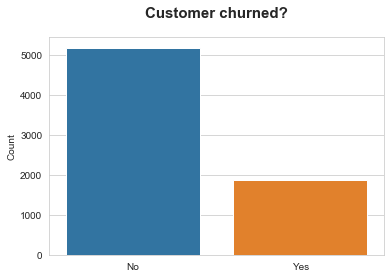

In [4]:
# Take a look at how many customers churned and how many stayed
target_dist = X_full['Churn'].value_counts()
print('Customers who stayed:  ', target_dist[0])
print('Customers who churned:  ', target_dist[1])

# Visualize the customer churn distribution
sns.set_style('whitegrid')
sns.barplot(x=target_dist.index, y=target_dist.values)
plt.title('Customer churned?', pad=20, fontsize=15, fontweight='bold')
plt.ylabel('Count')

It's clear that there exists class imbalance in our dataset because 26.5% of customers churned while 73.5% of customers stayed.

Since decision-tree based models are susceptible to frequency bias, we must address the class imbalance in one of two ways in order to make the distribution more equal:
1. Undersample the majority class (customer stayed)
2. Oversample the minority class (customer churned)

Since our dataset is relatively small at 7,043 rows, the better choice would be to pick option #2 and oversample the minority class.
This can be accomplished by the famous and very effective <u>S</u>ynthetic <u>M</u>inority-<u>O</u>versampling <u>T</u>echnique (**SMOTE** ). 

Let's continue our exploration, this time focusing in on our numerical data.

## 2.2) Explore our numerical data

In the previous section, we saw that `TotalCharges` is represented as an 'object' datatype even though it seems to represent numerical data. We investigate as follows:

In [5]:
# Check which datatypes are contained within 'TotalCharges'
X_full['TotalCharges'].apply(type).value_counts()

<class 'str'>    7043
Name: TotalCharges, dtype: int64

So it seems that `TotalCharges` consists only of strings.  Let's investigate to see if we'll be able to convert it to a float.

In [6]:
# Function to check if a string can be converted to a float
def is_convertible(value):
    """
    Checks to see whether a string can be converted to a float.
    Input:
        - A string
    Output:
        - A boolean indicating whether or not the string can be converted to a float
    """
    try:
        float(value)
        return True
    except ValueError:
        return False

    
    
# Initialize list of strings that can't be converted to a float
unconvertibles = []

# Iterate through an array of strings, and append unconvertible strings to a list
str_array = X_full['TotalCharges'].to_numpy()
for element in str_array:
    if is_convertible(element) == False:
        unconvertibles.append(element)

# See which strings (if any) are unconvertible
print("Unconvertibles:  ", unconvertibles)
print("Count of unconvertibles:  ", len(unconvertibles))

Unconvertibles:   [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Count of unconvertibles:   11


Apparently there are a eleven empty strings which can't be converted to a float.  Though we would normally handle this under the "data cleaning" stage, let's handle these values now so we can convert our data to floats in order to better visualize it later on.

In [7]:
# Convert from 'object' to 'float' while replacing strings containing whitespace with NaN
X_full['TotalCharges'] = pd.to_numeric(X_full['TotalCharges'], errors='coerce')

Now that we've converted `TotalCharges` to the float datatype, we can analyze its characteristics along with the rest of our numerical data.

In [8]:
# Get a sense of numerical data
X_full.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


### <h3><center> Interesting Observations: </center></h3>
1. `SeniorCitizen` seems to be a categorical representation of whether or not a customer is a senior citizen (class=1) or not (class=0)
    - This column has already been numerically encoded, so there is nothing for us to do here when it comes time to feature engineering.
2. `tenure` is the number of months a customer has stayed at the company.  It looks like the company has some loyal customers!
    - Our intuition tells us that this could be a useful predictor of customer churn.  Loyal customers might be unlikely to churn. 
    - There don't seem to be any outliers here, so this isn't something we have to worry aobut.
3. `MonthlyCharges` is the total amount a customer pays per month.
    - There don't seem to be any outliers here, so this isn't something we have to worry aobut.
4. `TotalCharges` contains 11 NaN values.
    - We will have to handle this later on using imputation.


Text(0.5, 0, 'Total payment amount')

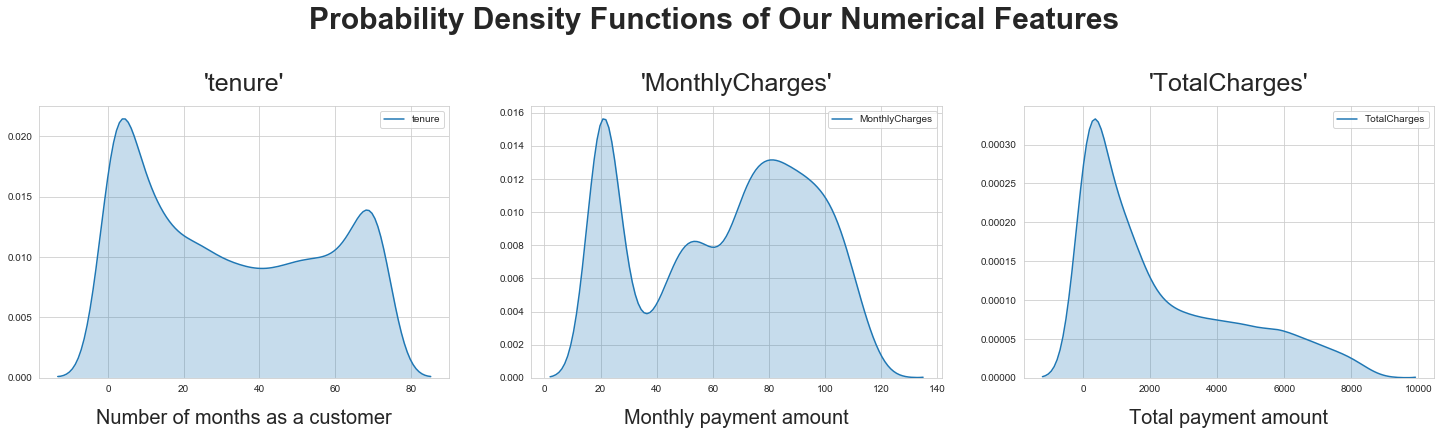

In [9]:
# Set style
sns.set_style('whitegrid')

# Set up for graphs to be side-by-side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,5), sharex=False, sharey=False)
plt.suptitle('Probability Density Functions of Our Numerical Features', 
             fontsize=30, fontweight='bold', y=1.155)

# Create graph showing distribution of 'tenure'
tenure_distPlot = sns.kdeplot(data=X_full['tenure'], shade=True, ax=axes[0])
axes[0].set_title("'tenure'", fontsize=25, pad=15)
axes[0].set_xlabel("Number of months as a customer", fontsize=20, labelpad=15)

# Create graph showing distribution of 'MonthlyCharges'
monthlyCharge_distPlot = sns.kdeplot(data=X_full['MonthlyCharges'], shade=True, ax=axes[1])
axes[1].set_title("'MonthlyCharges'", fontsize=25, pad=15)
axes[1].set_xlabel("Monthly payment amount", fontsize=20, labelpad=15)

# Create graph showing distribution of 'TotalCharges'
totalCharge_distPlot = sns.kdeplot(data=X_full['TotalCharges'], shade=True, ax=axes[2])
axes[2].set_title("'TotalCharges'", fontsize=25, pad=15)
axes[2].set_xlabel("Total payment amount", fontsize=20, labelpad=15)

### <h3><center> Interesting Observations: </center></h3>
1. The distribution for `tenure` seems to be bimodal, that is, customers either tend to be relatively new (0-9 months) or tend to have been with the company for an extended period time (5+ years)
    - The fact that customers are heavily weighted towards being relatively new indicates that there is a legitimate need to improve customer retention rates.  But that's why we're here!
    - If we can successfully predict which customers are in danger of churning and provide them incentives to stay, these "flight-risk" customers could actually end up staying with us for many years to come!
2. `MonthlyCharges` also seems to be bimodal, so customers either spend on the lower end of the spectrum (18-35 dollars) or--even more likely--on the higher end of the spectrum (70+ dollars).
3. Looking at`TotalCharges`, we can see that it is more likely for a customer to have spent a relatively small total amount (0-1,000 dollars) than it is to have spent a relatively high amount (4,000-5,000 dollars, for instance)


Now that we have some sense of how our numerical features are distributed overall, let's break things down a bit more and see how they're distributed when grouped by our target variable: `Churn`.

Text(0, 0.5, 'Total payment amount')

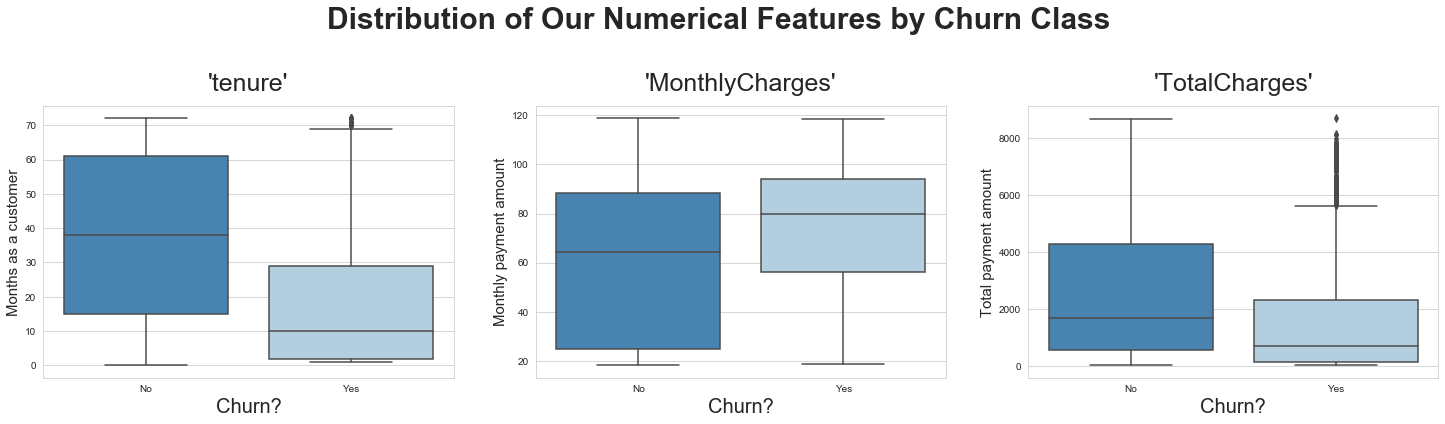

In [10]:
# Set up for graphs to be side-by-side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,5), sharex=False, sharey=False)
plt.suptitle('Distribution of Our Numerical Features by Churn Class', 
             fontsize=30, fontweight='bold', y=1.155)

# Create graph showing distribution of 'tenure'
tenure_boxPlot = sns.boxplot(x=X_full['Churn'], y=X_full['tenure'], 
                             ax=axes[0], palette='Blues_r')
axes[0].set_title("'tenure'", fontsize=25, pad=15)
axes[0].set_xlabel("Churn?", fontsize=20)
axes[0].set_ylabel("Months as a customer", fontsize=15)


# Create graph showing distribution of 'MonthlyCharges'
monthlyCharges_boxPlot = sns.boxplot(x=X_full['Churn'], y=X_full['MonthlyCharges'], 
                                     ax=axes[1], palette='Blues_r')
axes[1].set_title("'MonthlyCharges'", fontsize=25, pad=15)
axes[1].set_xlabel("Churn?", fontsize=20)
axes[1].set_ylabel("Monthly payment amount", fontsize=15)

# Create graph showing distribution of 'TotalCharges'
totalCharges_boxPlot = sns.boxplot(x=X_full['Churn'], y=X_full['TotalCharges'], 
                                   ax=axes[2], palette='Blues_r')
axes[2].set_title("'TotalCharges'", fontsize=25, pad=15)
axes[2].set_xlabel("Churn?", fontsize=20)
axes[2].set_ylabel("Total payment amount", fontsize=15)

### <h3><center> Interesting Observations: </center></h3>
1. `Tenure`
    - Unsurprisingly, customers who churn are usually the ones who have spent less time with the company
2. `MonthlyCharges`
    - As suspected, customers who churn tend to have higher monthly charges than customers who don't churn
        - Whether or not a customer can still afford to pay is likely a factor affecting churn rate
3. `TotalCharges`
    - Customers who churn tend to have lower total charges than customers who don't churn
        - Likely reflecting the fact that customers who churn are usually not with the company for very long
    
Interestingly, by looking at the `TotalCharges` column, there are a decent number of 'outlierly' customers who have spent a great deal of money over the years and still churn.  

Let's investigate these customers further to determine whether the outliers occur due to reporting error or whether their values are within the realm of possibility.

In [11]:
# Find the 25th and 75th percentile values of 'TotalCharge' for customers who churned
lower_percentile = X_full[X_full['Churn']=='Yes'].TotalCharges.quantile(.25)
upper_percentile = X_full[X_full['Churn']=='Yes'].TotalCharges.quantile(.75)

# Calculate the inter-quartile range
iqr = upper_percentile - lower_percentile

# Calculate the cut-off point after which a datapoint becomes an outlier
outlier_limit = upper_percentile + (1.5 * iqr)

# Dataframe consisting only rows of outlierly, abnormally high 'TotalCharge' customers who churned
outlier_tot_charge_churn = X_full[ (X_full['Churn']=='Yes') & (X_full['TotalCharges'] > outlier_limit) ]

# Interesting statistics of abnormally high 'TotalCharge' customers who churned
num_totCharge_outliers = len(outlier_tot_charge_churn.index)
avg_spent_outliers = outlier_tot_charge_churn.TotalCharges.mean()
tot_spent_outliers = num_totCharge_outliers * avg_spent_outliers

print('Number of outlierly customers:  ', num_totCharge_outliers)
print("Average total amount spent per outlierly customer:  ", avg_spent_outliers)
print('Total amount spent by outlierly customers:  ', tot_spent_outliers)


Number of outlierly customers:   109
Average total amount spent per outlierly customer:   6670.281192660553
Total amount spent by outlierly customers:   727060.6500000003


There are 109 such best-paying customers who ended up churning.  On average, each person spent \\$6,670 over their entire customer lifetime, and as a whole, the entire group of outliers ended up contributing approximately \\$727,060 to the company's bottom line. 

These individuals are our most valuable customers, and we would like to retain them as much as possible.  By being able to predict whether or not such customers are at risk of leaving, we will be better placed to offer these inviduals incentives to stay.

As our EDA is wrapping up, let's do a final check to see the correlations between our numerical features.  

If any two features are overly correlated, it would be valuable to remove one of them to solve the problem of multicollinearity.

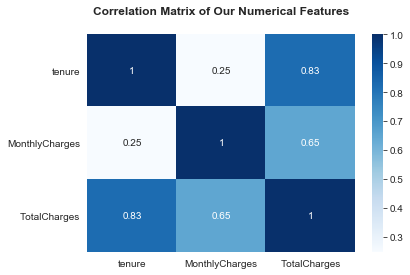

In [12]:
# Generate the correlation matrix of our numerical features
corrMatrix = X_full[['tenure', 'MonthlyCharges', 'TotalCharges']].corr()

# Visualize the correlation matrix
plt.title('Correlation Matrix of Our Numerical Features', pad=20, fontweight='bold')
sns.heatmap(corrMatrix, cmap='Blues', annot=True)

### <h3><center> Interesting Observations: </center></h3>
1. There's a high correlation between `tenure` and `TotalCharges`
    - This fits our intuition that the longer a customer has been with the company, the more they will have paid.
    - Despite the high correlation between the two features, it is not enough to justify removing one of them because they are not excessively correlated.
2. There's a moderate correlation between `MonthlyCharges` and `TotalCharges`
    - It makes sense that the more you pay on a month-to-month basis, the more you will have spent overall.
    - The reason why `MonthlyCharges` is not as correlated to `TotalCharges` as `tenure` is likely due to the company being subscription based
3. There's a low correlation between `tenure` and `MonthlyCharges`

Given the fact that `TotalCharges` is more correlated to `tenure` than it is to `MonthlyCharges`, then this could inform the company business model.  In other words, it seems that the trope "slow and steady wins the race" holds true, as customer value is more determined by time spent with the company than by their monthly payments.  If this is indeed the case, then it would be interesting to see if high monthly payments lead to increased churn rates among customers.

Since we've completed our EDA of the numerical columns, let's turn our attention to our categorical data.

## 2.3) Explore our categorical data

### <h3><center> Visualizing Target Distribution by Gender </center></h3>

It would be interesting to see whether gender plays a role in predicting customer churn.  We visualize the churn data as follows:

Text(0, 0.5, 'Count')

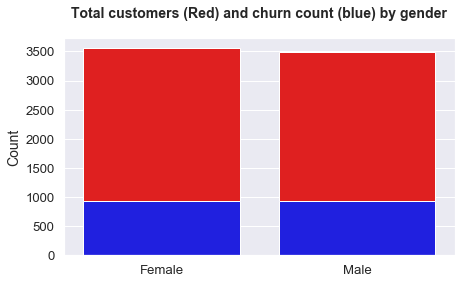

In [13]:
# Set the style of our visualizations
sns.set_style('whitegrid')
sns.set(font_scale = 1.2)
plt.figure(figsize=(7,4))

# Create the barplot (in blue) depicting customer count--by gender
gender_dist = X_full['gender'].value_counts()
sns.barplot(x=gender_dist.index, y=gender_dist.values, color='red')

# Create the barplot (in orange) depicting customer churn count--by gender
gender_churn_dist = X_full[X_full.Churn=='Yes']['gender'].value_counts()
sns.barplot(x=gender_churn_dist.index, y=gender_churn_dist.values, color='blue')

# Label the graph
plt.title('Total customers (Red) and churn count (blue) by gender', 
          pad=20, fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14)

As seen by the equal distribution, gender does not seem to play a role in determining whether a customer will churn or not.  
Now that we know this, `gender` would be a good column to drop in order to simplify our model and reduce the *curse of dimensionality*

Let's visualize the rest of our attributes to see which columns are droppable.

### <h3><center> Visualizing Target Distribution of Our Categorical Variables </center></h3>

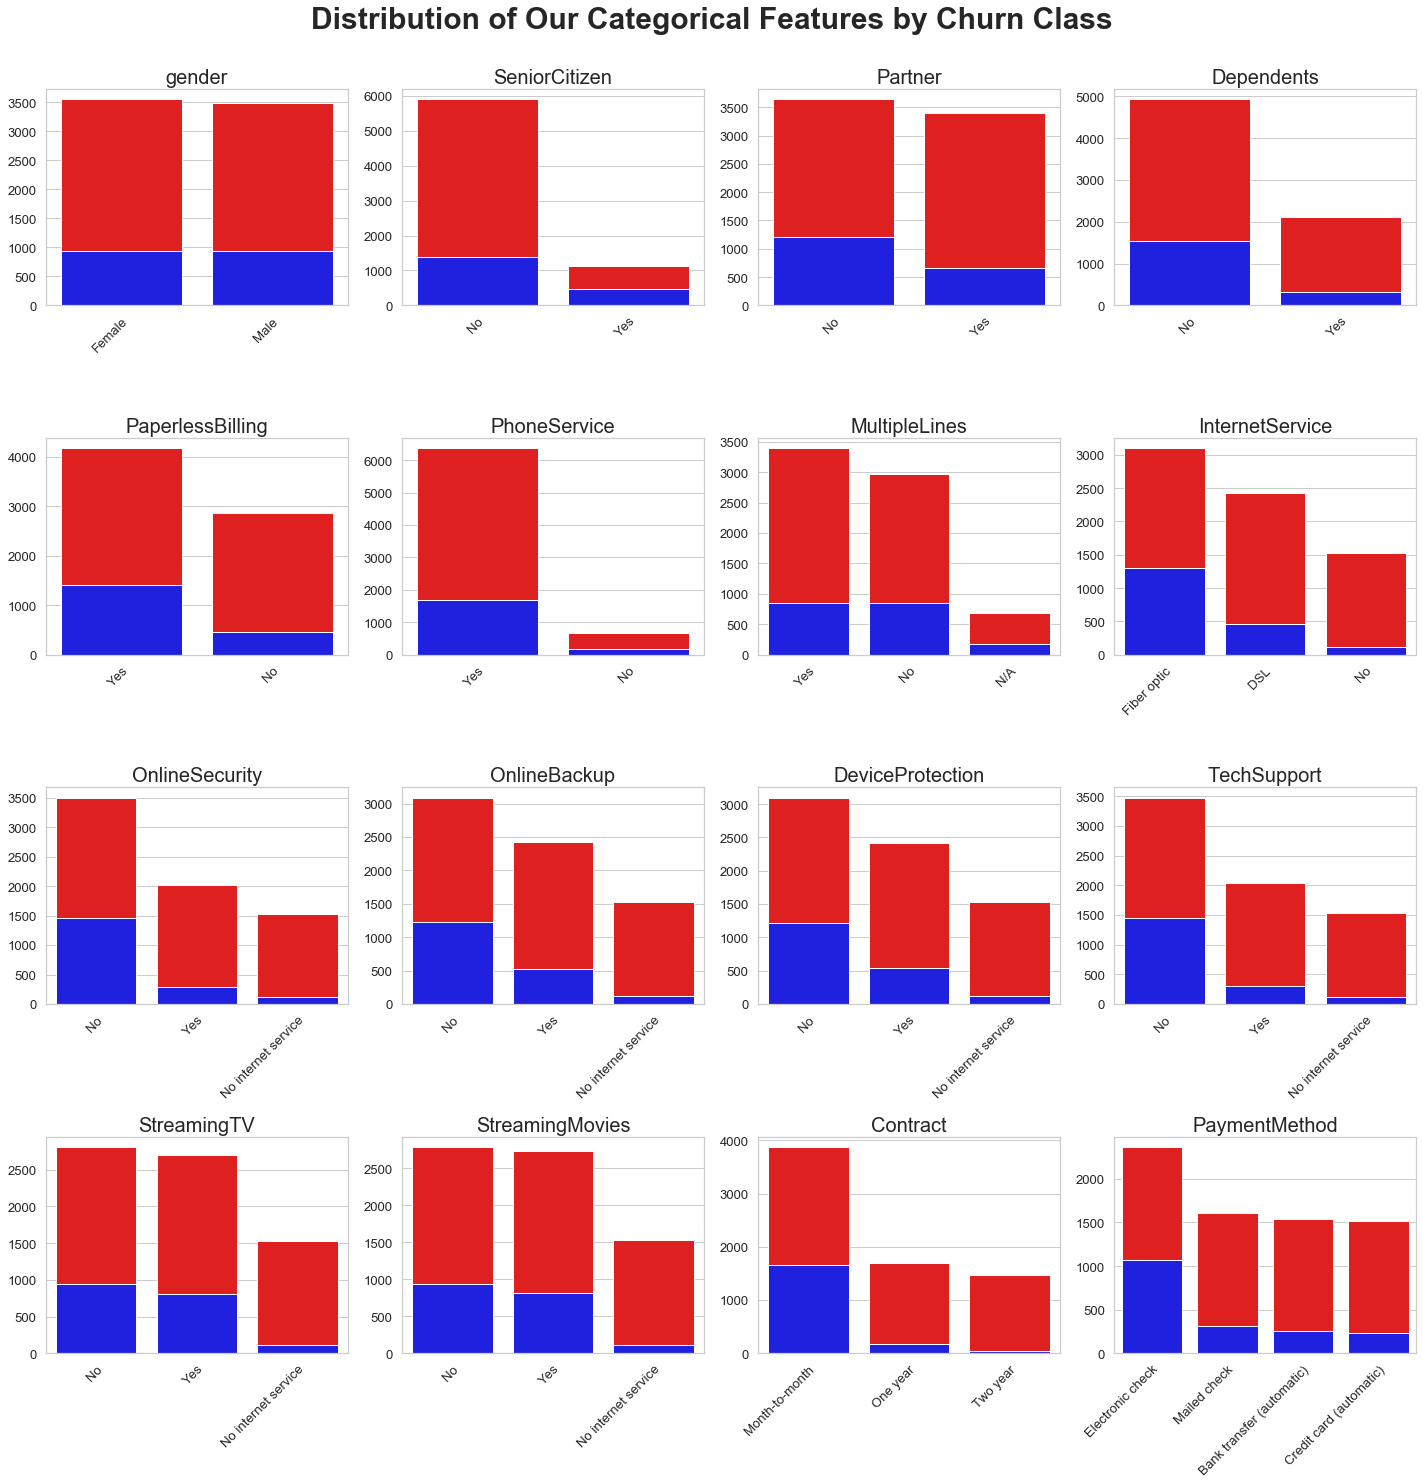

In [14]:
# Find and replace categorical values to make visualization more readable
X_full['SeniorCitizen'].astype('object')
X_full.replace(to_replace={'SeniorCitizen': {0:'No', 1:'Yes'}}, inplace=True)
X_full.replace(to_replace={'MultipleLines': {'No phone service':'N/A'}}, inplace=True)

# Get a list of attributes to visualize
cat_cols_viz = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                'PaperlessBilling', 'PhoneService', 'MultipleLines', 'InternetService',
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


# Set style
sns.set_style('whitegrid')

# Set up subplot to display graphs
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,20), sharex=False, sharey=False)
plt.suptitle('Distribution of Our Categorical Features by Churn Class', 
             fontsize=30, fontweight='bold', y=1.032)

# Initialize row and column index iterators in preparation for filling in the subplot
row_iterator = 0
col_iterator = 0

# Fill in the subplot
for col in cat_cols_viz:
    # Adjust indices once we reach the end of a row (moving from left to right)
    if col_iterator == 4:
        col_iterator = 0
        row_iterator = row_iterator + 1
    
    
    # Initialize value count series
    valCount_series = X_full[col].value_counts()
    churn_valCount_series = X_full[X_full.Churn=='Yes'][col].value_counts()
    
    
    # Create the barplot (in blue) depicting customer count--by column
    sns.barplot(x=valCount_series.index, y=valCount_series.values, color='Red', ax=axes[row_iterator][col_iterator])
    
    # Create the barplot (in orange) depicting customer churn count--by column
    sns.barplot(x=churn_valCount_series.index, y=churn_valCount_series.values, color='blue', ax=axes[row_iterator][col_iterator])

    # Label the graph
    axes[row_iterator][col_iterator].set_title('%s' % col, fontsize=20)
        
    # Rotate xlabels
    plt.sca(axes[row_iterator, col_iterator])
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')    
    
    # Increment row and column indices
    col_iterator = col_iterator + 1

    
# Adjust spacing of subplot
fig.tight_layout()

### <h3><center> Interesting Observations: </center></h3>
1. Seemingly important features:
    - `Contract`: the longer the contract, the less likely a customer is to churn.
    - `PaymentMethod`: customers paying via electronic check are more likely to churn. 
    - `OnlineSecurity`: customers with no online security are more likely to churn.
    - `TechSupport`: customers receiving no tech support are more likely to churn.
2. Seemingly unimportant features:
    - `PhoneService` and `MultipleLines`: both have similar distributions across their different categories.  
        - The distributions aren't as balanced as the one we see with `gender`, so while the two features may not contribute much to the model, it might be worth keeping them in the end. 

Now that we've explored our data, it's time to perform data cleaning in order to prepare our data for modeling.

# 3.0)  Data Cleaning

In general, the dataset is very clean because after checking these things, we found that:
1. Our target column is complete and doesn't contain any NaN
    - No rows need to be dropped for this reason
2. Most columns are complete and don't contain any NaN
    - No columns need to be dropped for this reason
3. Our features don't leak information from the future (after the customer churned)
    - No columns need to be dropped for this reason
4. No features are redundant or excessively correlated
    - No columns need to be dropped for this reason
5. Though there are outlierly customers in terms of `TotalCharge`, the payment totals are not outside the realm of possibility
    - No rows need to be dropped for this reason

Our dataset isn't perfect, however, so we had to do the following to clean our data:
1. Convert elements of `TotalCharges` from 'strings' to 'floats'
2. Find and replace empty strings in `TotalCharges` with NaN

Now what's left to do is:
1. Drop the `gender` column since it doesn't contribute to our model. 
2. Remove white space from our value classes to make things more uniform.
3. Make binary value classes more descriptive
    - This will be imporant when we begin combining features during feature engineering so that we know what represents what.
4. Remove any duplicate entries in our data set

In [15]:
# Drop the 'gender' column from our dataset since it doesn't contribute to our model
X = X_full.drop('gender', axis=1)

# Remove whitespace from value classes and replace with '_'
whitespace_cols = cat_cols_viz[7:]
X[whitespace_cols] = X[whitespace_cols].stack().str.replace(' ', '_').unstack()

# Make value classes more descriptive
X.replace(to_replace={'SeniorCitizen': {'No':'Not_SenCit', 'Yes':'SeniorCitizen'}}, inplace=True)
X.replace(to_replace={'Partner': {'No':'No_Partner', 'Yes':'Partner'}}, inplace=True)
X.replace(to_replace={'Dependents': {'No':'No_Dependents', 'Yes':'Dependents'}}, inplace=True)
X.replace(to_replace={'PaperlessBilling': {'No':'No_PaperlessBill', 'Yes':'PaperlessBill'}}, inplace=True)
X.replace(to_replace={'PhoneService': {'No':'No_PhoneService', 'Yes':'PhoneService'}}, inplace=True)
X.replace(to_replace={'MultipleLines': {'No':'No_MultiLines', 'Yes':'MultiLines', 'N/A': 'No_PhoneService'}}, inplace=True)
X.replace(to_replace={'InternetService': {'No':'No_internet_service'}}, inplace=True)
X.replace(to_replace={'OnlineSecurity': {'No':'No_OnlineSecurity', 'Yes':'OnlineSecurity'}}, inplace=True)
X.replace(to_replace={'OnlineBackup': {'No':'No_OnlineBackup', 'Yes':'OnlineBackup'}}, inplace=True)
X.replace(to_replace={'DeviceProtection': {'No':'No_DeviceProtection', 'Yes':'DeviceProtection'}}, inplace=True)
X.replace(to_replace={'TechSupport': {'No':'No_TechSupport', 'Yes':'TechSupport'}}, inplace=True)
X.replace(to_replace={'StreamingTV': {'No':'No_StreamingTV', 'Yes':'StreamingTV'}}, inplace=True)
X.replace(to_replace={'StreamingMovies': {'No':'No_StreamingMov', 'Yes':'StreamingMov'}}, inplace=True)

# Using 'customerID', check to see if there are any duplicate entries
print('Number of duplicate entries:  ', X.index.duplicated().sum())

Number of duplicate entries:   0


It looks like there aren't any duplicate entries, so our data set looks to be fully cleaned!  Now it's time to do some feature engineering.

# 4.0)  Feature Engineering




In this section, we will:
1. Investigate and impute missing values found in `TotalCharges`
2. Generate novel features
3. Encode our categorical features
    - Map ordinal values to appropriate integers
    - One-hot encode nominal values

But before we do, let's separate the target from our predictors.

In [16]:
from sklearn.model_selection import train_test_split

# Separate target from predictors
y = X['Churn']
X.drop('Churn', axis=1, inplace=True)

## 4.1) Impute missing values

Let's first start off by deciding how to impute missing values found in `TotalCharges`.  Though we *could* impute these values using either the mean or median of the training data (actually the median would be preferable since `TotalCharges` has a skewed distribution), we suspect that there might be some hidden meaning behind these NaN's which might be masked if we imputed in this manner.


Recall that these missing values were originally strings of empty text, which may suggest that the value for `TotalCharge` should have been 0.  However, if there are any entries where `TotalCharges` is 0, then this theory would likely be incorrect because strings representing zero total charge would then be represented as '0' instead of the empty string.

Let's test this theory out by checking whether there are any entries where `TotalCharges` is 0.

In [17]:
# Check how many 0's are found within 'TotalCharges'
totCharges_zeroes = X[X['TotalCharges'] == 0].shape[0]
print('There are  ', totCharges_zeroes, "  representations of '0' found within 'TotalCharges'")

There are   0   representations of '0' found within 'TotalCharges'


Apparently there are zero representations of '0' found within `TotalCharges`.  Thus, it's beginning to look more and more likely that the empty string originally found within `TotalCharges` is intented to represent zero total charge.

To solidify our theory, let's look at `tenure` and `MonthlyCharges` to see if it makes sense that the empty string under `TotalCharges` does indeed represent 0.

In [18]:
# DataFrame of customers whose 'TotalCharges' was the empty string
totCharges_nan = X[X['TotalCharges'].isnull()]

# Find how many customers there are whose 'TotalCharges' was the empty string
print("There are ", totCharges_nan.shape[0], " customers whose 'TotalCharges' was the empty string")

# Get average 'tenure' of customers whose 'TotalCharges' was the empty string
print("The average TENURE of this subset is:  ", 
      totCharges_nan['tenure'].mean())

# Get average 'MonthlyCharges' for customers whose 'TotalCharges' was the empty string
print("The average MONTHLY CHARGE of this subset is:  ", 
      totCharges_nan['MonthlyCharges'].mean())

# Check if any customers whose 'TotalCharges' was the empty string had a monthly charge of 0
print('Did any such customers have a monthly charge of 0?    ', 0 in totCharges_nan['MonthlyCharges'].values)

There are  11  customers whose 'TotalCharges' was the empty string
The average TENURE of this subset is:   0.0
The average MONTHLY CHARGE of this subset is:   41.41818181818181
Did any such customers have a monthly charge of 0?     False


# <h3><center> Interesting Observations: </center></h3>
1. Individuals whose `TotalCharges` was the empty string are all brand new customers
2. All such customers have a non-zero value associated with `MonthlyCharges`


From everything we have just learned, I hypothesize that customers whose `TotalCharges` was the empty string are brand new customers who signed up for a monthly subscription but haven't yet made a payment.  Thus, the empty string for `TotalCharges` should really represent '0'.
    

Now that we know how to impute the NaN's in `TotalCharges`, let's find and replace NaN with 0.00.

In [19]:
# Find and replace NaN with 0 in 'TotalCharges'
X.fillna({'TotalCharges': 0}, inplace=True)

Since the NaN's in `TotalCharges` likely hold predictive power, we *could* add a missing value indicator (as a feature) in order to further highlight these missing values.  

However, we decided against doing this for the following reasons:
1. There are no other 0's in `TotalCharges` besides the ones we generated, so a value of 0 already stands out
2. Missing value indicator feature would be a sparse series of ~7,000 zeroes and 11 one's.  Overly complicating our model without providing much valuable information is not worth the tradeoff of efficiency and memory space.


But now that we finished imputing all values and we're just starting to think about generating new features, let's begin with some feature engineering!!

## 4.2) Generate novel features

In this section we will:
1. Combine some of our categorical features
2. Perform grouping operations
3. Encode our categorical features

### <h3><center> Combining Categorical Features </center></h3>

In [20]:
# Generate new features by combining existing ones
X['SenCit_Dependents'] = X['SeniorCitizen'] + '_' + X['Dependents']
X['Partner_Dependents'] = X['Partner'] + '_' + X['Dependents']
X['SenCit_Partner'] = X['SeniorCitizen'] + '_' + X['Partner']
X['SenCit_Contract'] = X['SeniorCitizen'] + '_' + X['Contract']
X['SenCit_TechSupport'] = X['SeniorCitizen'] + '_' + X['TechSupport']
X['SenCit_PayMeth'] = X['SeniorCitizen'] + '_' + X['PaymentMethod']

### <h3><center> Aggregations / Group Statistics </center></h3>

In [21]:
# Create column giving the average of 'TotalCharges' by contract length
temp1 = X.groupby('Contract')['TotalCharges'].agg(['mean']).rename({'mean':'Contract_mean_totCharges'},axis=1)
X = pd.merge(X, temp1, on='Contract', how='left')

# Create column giving the difference in 'TotalCharges' and the average of 'TotalCharges' by contract length
X['Contract_totCharges_diff'] = X['TotalCharges'] - X['Contract_mean_totCharges']


# Create column giving the average of 'MonthlyCharges' by payment method
temp2 = X.groupby('PaymentMethod')['MonthlyCharges'].agg(['mean']).rename({'mean':'PayMeth_mean_monthCharges'},axis=1)
X = pd.merge(X, temp2, on='PaymentMethod', how='left')

# Create column giving the difference in 'MonthlyCharges' and the average of 'MonthlyCharges' by payment method
X['PayMeth_monthCharges_diff'] = X['MonthlyCharges'] - X['PayMeth_mean_monthCharges']

In [22]:
# Round values to two decimal places
X = X.round(2)

### <h3><center> Encode Categorical Features </center></h3>

In [23]:
### Ordinal Encoding

# Ordinal encoding of 'MultipleLines'
multiLines_dict = {'No_PhoneService':0, 'No_MultiLines':1, 'MultiLines':2}
X['MultipleLines_Ordinal'] = X['MultipleLines'].map(multiLines_dict)

# Ordinal encoding of 'InternetService'
intServ_dict = {'No_internet_service':0, 'DSL':1, 'Fiber_optic':2}
X['InternetService_Ordinal'] = X['InternetService'].map(intServ_dict)

# Ordinal encoding of 'Contract'
contract_dict = {'Month-to-month':0, 'One_year':1, 'Two_year':2}
X['Contract_Ordinal'] = X['Contract'].map(contract_dict)

# Drop unnecessary columns that have been encoded
ordinal_drop_cols = ['MultipleLines', 'InternetService', 'Contract']
X.drop(ordinal_drop_cols, axis=1, inplace=True)

In [24]:
### One-hot Encoding

from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to the relevant columns
OH_col_names = ['SeniorCitizen', 'Partner', 'Dependents', 
           'PaperlessBilling', 'PhoneService', 'OnlineSecurity', 
           'OnlineBackup', 'DeviceProtection', 'TechSupport',
           'StreamingTV', 'StreamingMovies', 'PaymentMethod',
           'SenCit_Dependents', 'Partner_Dependents', 'SenCit_Partner',
           'SenCit_Contract', 'SenCit_TechSupport', 'SenCit_PayMeth']
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(X[OH_col_names]))

# Replace default column names with more descriptive ones
OH_cols.columns = OH_encoder.get_feature_names(OH_col_names)

# One-hot encoding removed index; put it back
OH_cols.index = X.index

# Remove categorical columns (will replace with one-hot encoding)
X.drop(OH_col_names, axis=1, inplace=True)

# Add one-hot encoded columns to numerical features
X = pd.concat([X, OH_cols], axis=1)


## 4.3) Final Preparation of the Data

### <h3><center> Oversample the Minority Class </center></h3>

Oversampling via **SMOTE** will help combat class imbalance and lead to more accurate predictions.

In [25]:
from imblearn.over_sampling import SMOTE

# Oversample our dataset using SMOTE to deal with class imbalance
oversample = SMOTE(sampling_strategy=0.5, random_state=42)
X, y = oversample.fit_resample(X, y)

### <h3><center> Perform Feature Scaling </center></h3>
Our goal is to test an entire suite of classification algorithms on our data in order to pick out the candidates that are best suited to the structure of our problem.  In order to make the comparison a fair one, we must scale our features because some of the algorithms to be tested (Logistic Regression, SVM, Linear Discriminant Analysis, and KNN) are based on the assumption that data is standardized and centered around 0.

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Define the columns we wish to transform
scale_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 
              'Contract_mean_totCharges', 'Contract_totCharges_diff', 
              'PayMeth_mean_monthCharges', 'PayMeth_monthCharges_diff',]

# Scale the relevant columns
transformer = ColumnTransformer([('scaler', StandardScaler(), scale_cols)], 
                                remainder='passthrough')
scaled_X = pd.DataFrame(transformer.fit_transform(X))

# Transformation removed column names; put them back
scaled_X.columns = X.columns


# 5.0)  Analysis of Model Candidates

In order to choose our final model, we will first evaluate an entire suite of algorithms to determine which candidates are best suited for the structure of our project.  

Let's start comparing!

## 5.1) Reduce the Size of Our Datasets

In [27]:
## Function to reduce the DF size
def df_mem_reducer(df):
    """
    Reduces the memory usage of a given dataframe via conversion of numeric attribute datatypes
    Input:
        - df: a Pandas dataframe
    Output: 
        - the same Pandas dataframe that uses less memory
    """
    
    # Original memory usage of dataframe in MB
    start_mem = df.memory_usage().sum() / 1024**2    
    
    # Conversion of numerical datatypes
    num_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for col in df.columns:
        col_dtype = df[col].dtypes            
        if col_dtype in num_dtypes:
            col_min = df[col].min()
            col_max = df[col].max()
            if str(col_dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else: 
                    df[col] = df[col].astype(np.int64)  
            else:
                if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    
    end_mem = df.memory_usage().sum() / 1024**2
    
    print('Original memory usage:  ', start_mem, '  MB')
    print('Final memory usage:  ', end_mem, '  MB')
    print('Memory of DataFrame reduced by:  ', ((start_mem - end_mem) / start_mem) * 100, '%')
        
    return df

In [28]:
# Reduce memory usage of scaled_X
scaled_X = df_mem_reducer(scaled_X)

Original memory usage:   4.3817901611328125   MB
Final memory usage:   1.0955390930175781   MB
Memory of DataFrame reduced by:   74.99791060888339 %


In [29]:
# Reduce memory usage of X
X = df_mem_reducer(X)

Original memory usage:   4.3817901611328125   MB
Final memory usage:   1.0659332275390625   MB
Memory of DataFrame reduced by:   75.67356746121567 %


## 5.2) Run Our Testing Suite and Analyze the Results

LR :   Mean =   0.8550249160461927    STD =    0.008822118543211015
LDA :   Mean =   0.8478717239290782    STD =    0.00879903629327962
KNN :   Mean =   0.8107272593424305    STD =    0.010426041583246821
NB :   Mean =   0.8146713491967887    STD =    0.010246950525858714
SVM :   Mean =   0.8467721830941072    STD =    0.00848706686459326
RF :   Mean =   0.8628962269933593    STD =    0.008170414491863034


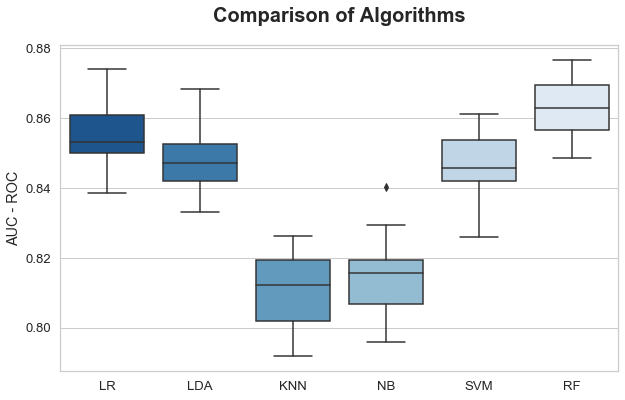

In [30]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score


# Import linear ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Import non-linear ML algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Initialize our testing suite
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
results = []
model_names = []
all_models = []
all_models.append(('LR', LogisticRegression(max_iter=1000)))
all_models.append(('LDA', LinearDiscriminantAnalysis()))
all_models.append(('KNN', KNeighborsClassifier()))
all_models.append(('NB', GaussianNB()))
all_models.append(('SVM', SVC()))
all_models.append(('RF', RandomForestClassifier()))

# Run the tests
for name, model in all_models:
    scores = cross_val_score(model, scaled_X, y, cv=cv, scoring='roc_auc')
    results.append(scores)
    model_names.append(name)
    print(name, ':  ', 'Mean =  ', scores.mean(), '  ', 'STD =   ', scores.std())
    
# Visualize the results
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.boxplot(x=model_names, y=results, palette='Blues_r')
plt.title('Comparison of Algorithms', fontsize=20, pad=23, fontweight='bold')
plt.ylabel('AUC - ROC')
plt.show()

As we can see, our **Random Forest** model performed the best with Logistic Regression, Linear Discriminant Analysis and Support Vector Machines not far behind.  

# 6.0)  Conclusion


In this project, we analyzed customer data to predict whether customers would churn or not churn.
Our trained models had the following predictive potential:

1. **Random Fores**:              AUC-ROC = 0.86
2. **Logistic Regression**:  AUC-ROC = 0.86

As for our next steps, we will pass over the Random Forest model to the company's Customer Retention group in order to better inform their business strategy. By targeting those customers who are most likely to churn, the company would be able to cut costs via more efficient allocation of resources towards customer incentive programs. 

Furthermore, the company would enjoy increased revenue via its improved retention strategy.  By using our model to help convert 'high-flight-risk' customers to a more loyal following, the company would be looking at maintaing a valuable, mutually-beneficial relationship with its customer base for many years to come.